## 0 - Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/')
%pwd

'/content/drive/MyDrive/Colab Notebooks/ML_class/2023/8_transfer learning'

# 0. Trasnfer Learning  

- In this practice, you will learn how to train a convolutional neural network for image classification using transfer learning.

- We are going to focus on how to use the pre-trained models for trasnfer learning. The entire practices consists of the following main steps.

- Model Inference Process
 1. Load Data
 2. Trainig the model
 3. Finetuning the CNN
 4. Save and Load model
 5. CNN as fixed feature extractor


# 1. Load Data

- We will use torchvision and torch.utils.data packages for loading the data.

- The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

- This dataset is a very small subset of imagenet.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/content/drive/My Drive/Colab Notebooks/ML_class/transfer learning/hymenoptera_data/'
data_dir = './hymenoptera_data/'
print(os.path.join(data_dir, 'train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#print(image_datasets)
print(len(image_datasets['train']))
print(len(image_datasets['val']))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

./hymenoptera_data/train
244
153


 - **(Optional) Visualize a few images** : Let’s visualize a few training images so as to understand the data augmentations.



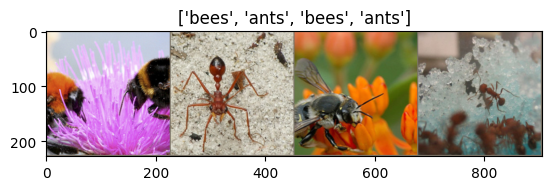

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Check**

* model.parameters() vs. model.state_dict()




In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
for idx, para in enumerate(net.parameters()):
  print(f"idx:{idx+1}, para.shape:{para.shape}")
print()
for key, value in net.state_dict().items():
  print(f"{key} : {value.shape}")

idx:1, para.shape:torch.Size([6, 3, 5, 5])
idx:2, para.shape:torch.Size([6])
idx:3, para.shape:torch.Size([16, 6, 5, 5])
idx:4, para.shape:torch.Size([16])
idx:5, para.shape:torch.Size([120, 400])
idx:6, para.shape:torch.Size([120])
idx:7, para.shape:torch.Size([84, 120])
idx:8, para.shape:torch.Size([84])
idx:9, para.shape:torch.Size([10, 84])
idx:10, para.shape:torch.Size([10])

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


In [ ]:
for name, para in net.named_modules():
  print(f"{name}:*:{para}")

:*:Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1:*:Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
pool:*:MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2:*:Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
fc1:*:Linear(in_features=400, out_features=120, bias=True)
fc2:*:Linear(in_features=120, out_features=84, bias=True)
fc3:*:Linear(in_features=84, out_features=10, bias=True)


# 2. Training the model

- **Defining train_model function for a general function**. Here, we will illustrate:
 - Scheduling the learning rate
 - Saving the best model

- In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  #with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

 - **Visualizing the model predictions** : Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#3. Finetuning the convnet

- Load a pretrained model and reset final fully connected layer.

In [ ]:
temp_model = models.resnet18(pretrained=True)
#for k, v in temp_model.state_dict().items():
#  print(f"{k} : {v.shape}")
for name, para in temp_model.named_modules():
  print(f"{name}:*:{para}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 299MB/s]


:*:ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)

In [ ]:
for param in temp_model.parameters():
  print(f"required_grad:{param.requires_grad}")

required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_gra

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


 - **Train :** It should take around 15-25 min on CPU. On GPU though, it takes less than a minute

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5748 Acc: 0.7008
val Loss: 0.6116 Acc: 0.7386

Epoch 1/24
----------
train Loss: 0.4514 Acc: 0.8156
val Loss: 0.2016 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4535 Acc: 0.8197
val Loss: 0.1838 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5504 Acc: 0.7992
val Loss: 0.2511 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5756 Acc: 0.7910
val Loss: 0.3228 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.6311 Acc: 0.7295
val Loss: 0.2473 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4045 Acc: 0.8402
val Loss: 0.3122 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3483 Acc: 0.8525
val Loss: 0.2560 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3227 Acc: 0.8525
val Loss: 0.3027 Acc: 0.8431

Epoch 9/24
----------
train Loss: 0.3165 Acc: 0.8607
val Loss: 0.2496 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.2642 Acc: 0.9016
val Loss: 0.2313 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3738 Acc: 0.8320
val Loss: 0.2351 Acc: 0.9020

Ep

- **Evaluate** : Let’s  display predictions for a few images

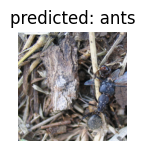

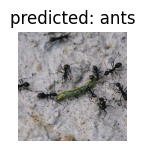

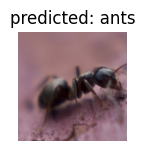

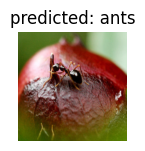

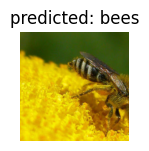

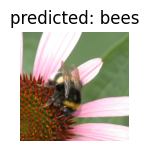

In [ ]:
visualize_model(model_ft)

#4. Saving & Loading trained Model  
- When it comes to saving and loading models, there are three core functions to be familiar with:
 - torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
 - torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).
 - torch.nn.Module.load_state_dict: Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.
 - For more details : https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
# Save model
torch.save(model_ft.state_dict(), "model.pth")

# Load model
model_ft.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

#5. ConvNet as fixed feature extractor

- Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

- **Train and evaluate**
 - On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5193 Acc: 0.7377
val Loss: 0.2243 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4976 Acc: 0.7869
val Loss: 0.1910 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.6728 Acc: 0.6803
val Loss: 0.6855 Acc: 0.7451

Epoch 3/24
----------
train Loss: 0.5782 Acc: 0.7787
val Loss: 0.2058 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3563 Acc: 0.8689
val Loss: 0.1943 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4648 Acc: 0.8156
val Loss: 0.5701 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.5025 Acc: 0.8115
val Loss: 0.3027 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4282 Acc: 0.8197
val Loss: 0.1929 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3876 Acc: 0.8238
val Loss: 0.2089 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3058 Acc: 0.8566
val Loss: 0.1849 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3875 Acc: 0.8361
val Loss: 0.2104 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3505 Acc: 0.8607
val Loss: 0.2236 Acc: 0.9216

Ep

 - **(Optional) Visualize a few images** : Let’s  display predictions for a few images

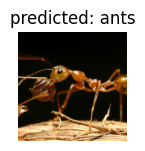

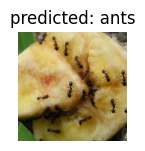

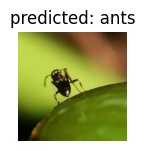

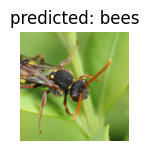

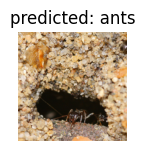

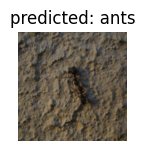

In [ ]:
visualize_model(model_conv)

#plt.ioff()
#plt.show()

# 6. References

- PyTorch : TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
 - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#further-learning